In [2]:
!pip install torchsummary

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader,random_split
from torchvision import datasets, transforms, models 
from torchvision.utils import make_grid
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc
import torch.optim as optim
from tqdm import tqdm
from torchsummary import summary


import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

from sklearn.metrics import confusion_matrix
import seaborn as sns

import shutil

import warnings
warnings.filterwarnings("ignore")

In [4]:
BATCH_SIZE = 5
LR = 0.0001

In [5]:
train_transform=transforms.Compose([
        transforms.RandomRotation(10),      # rotate +/- 10 degrees
        transforms.RandomHorizontalFlip(),  # reverse 50% of images
        transforms.RandomResizedCrop(224),         # randomly crop to 224 pixels
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # randomly adjust color
        transforms.RandomAffine(degrees=10, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=10), # apply random affine transformation
        transforms.RandomPerspective(distortion_scale=0.2), # apply random perspective transformation
        transforms.GaussianBlur(kernel_size=3), # apply Gaussian blurring
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
])


In [6]:
output_dir = "/content/kaggle/"


In [7]:
train_dataset = datasets.ImageFolder(root='/kaggle/input/flower-classification-5-classes-roselilyetc/Flower Classification V2/V2/Training Data', transform=train_transform)
test_dataset = datasets.ImageFolder(root='/kaggle/input/flower-classification-5-classes-roselilyetc/Flower Classification V2/V2/Testing Data', transform=train_transform)
val_dataset = datasets.ImageFolder(root='/kaggle/input/flower-classification-5-classes-roselilyetc/Flower Classification V2/V2/Validation Data', transform=train_transform)

In [8]:
class_names=train_dataset.classes
print(class_names)
print(len(class_names))

['Aster', 'Daisy', 'Iris', 'Lavender', 'Lily', 'Marigold', 'Orchid', 'Poppy', 'Rose', 'Sunflower']
10


In [9]:
# Define the dataloaders
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

In [10]:
class MobileNetV2(nn.Module):
    def __init__(self, num_classes=5):
        super(MobileNetV2, self).__init__()
        self.features = models.mobilenet_v2(pretrained=False).features
        self.classifier = nn.Linear(1280, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = nn.functional.adaptive_avg_pool2d(x, 1).reshape(x.shape[0], -1)
        x = self.classifier(x)
        return x

In [11]:
# Define the ResNet18 architecture
class ResNet18(nn.Module):
    def __init__(self, num_classes=5):
        super(ResNet18, self).__init__()
        self.model = models.resnet18(pretrained=False)
        self.model.fc = nn.Linear(512, num_classes)

    def forward(self, x):
        x = self.model(x)
        return x

In [12]:
class VGG16(nn.Module):
    def __init__(self, num_classes=5):
        super(VGG16, self).__init__()
        self.features = models.vgg16(pretrained=False).features
        self.classifier = nn.Linear(512 * 7 * 7, num_classes)

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x

In [13]:
# Set the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [14]:
model1 = ResNet18(num_classes = len(class_names)).to(device)
model2 = VGG16(num_classes = len(class_names)).to(device)
model3 = MobileNetV2(num_classes = len(class_names)).to(device)


In [15]:
# Define the loss function and optimizer
criterion1 = nn.CrossEntropyLoss()
optimizer1 = optim.Adam(model1.parameters(), lr=LR)

criterion2 = nn.CrossEntropyLoss()
optimizer2 = optim.Adam(model2.parameters(), lr=LR)

criterion3 = nn.CrossEntropyLoss()
optimizer3 = optim.Adam(model3.parameters(), lr=LR)

In [24]:
batch_sizes = [8, 16, 32, 64, 128]
val_accs = []
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)

for batch_size in batch_sizes:

    # Train the model
    for epoch in range(10):
        for i, data in enumerate(train_dataloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer1.zero_grad()
            outputs = model1(inputs)
            loss = nn.CrossEntropyLoss()(outputs, labels)
            loss.backward()
            optimizer1.step()

        # Evaluate the model on the validation set
        correct = 0
        total = 0
        with torch.no_grad():
            for i, data in enumerate(train_dataloader, 0):
                inputs, labels = data[0].to(device), data[1].to(device)
                outputs = model1(inputs)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        val_acc = 100 * correct / total
        print(f'Batch size {batch_size}, Epoch {epoch+1}, Validation accuracy: {val_acc:.2f}%')
    
    val_accs.append(val_acc)
    print("\n")

Batch size 8, Epoch 1, Validation accuracy: 12.85%
Batch size 8, Epoch 2, Validation accuracy: 13.60%
Batch size 8, Epoch 3, Validation accuracy: 15.79%
Batch size 8, Epoch 4, Validation accuracy: 15.97%
Batch size 8, Epoch 5, Validation accuracy: 17.01%
Batch size 8, Epoch 6, Validation accuracy: 17.57%
Batch size 8, Epoch 7, Validation accuracy: 17.80%
Batch size 8, Epoch 8, Validation accuracy: 18.23%
Batch size 8, Epoch 9, Validation accuracy: 18.33%
Batch size 8, Epoch 10, Validation accuracy: 18.87%


Batch size 16, Epoch 1, Validation accuracy: 18.60%
Batch size 16, Epoch 2, Validation accuracy: 19.39%
Batch size 16, Epoch 3, Validation accuracy: 19.21%
Batch size 16, Epoch 4, Validation accuracy: 20.01%
Batch size 16, Epoch 5, Validation accuracy: 20.32%
Batch size 16, Epoch 6, Validation accuracy: 20.79%
Batch size 16, Epoch 7, Validation accuracy: 21.75%
Batch size 16, Epoch 8, Validation accuracy: 22.35%
Batch size 16, Epoch 9, Validation accuracy: 23.80%
Batch size 16, Epoc

KeyboardInterrupt: 

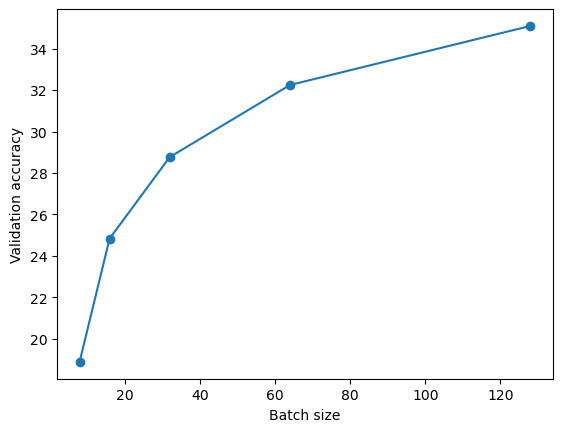

In [30]:
import matplotlib.pyplot as plt

plt.plot(batch_sizes, val_accs, '-o')
plt.xlabel('Batch size')
plt.ylabel('Validation accuracy')
plt.show()
